# Q4. Transfer learning (20 marks)

<b>When we learn to solve a new problem, we often leverage on knowledge that we have learned on related tasks. 
For example, when we learn how to play chess after learning how to play Chinese chess, we can often quickly learn new tactics for chess by relating to tactics that we have learned for Chinese chess.</b>
    
<b>Exploiting previously acquired knowledge on related tasks to learn how to solve new problems is known as transfer learning, and this idea has been applied to build machine learning systems too.
</b>

<b>In this question, we will exploit a model learned on a noisy version of MNIST to learn a model on MNIST.
</b>

<b>(a) (0 marks) 
The code below loads a model trained on a noisy version of MNIST, with all pixel values normalized to the range [0,1]. Some of the noisy MNIST images are shown on the left figure below, together with some of the original MNIST images shown on the right figure below for comparsion.</b>
<table>
    <tr>
        <td><img src='supplements/noisy_mnist.png' width=450></td>
        <td><img src='supplements/clean_mnist.png' width=450></td>
    </tr>
</table>
<b>The model is actually a feature network that converts an input image into a feature vector.
Read and run the code to understand how it works.
</b>

In [1]:
import torch
torch.manual_seed(1)
# load the feature network
feature_net = torch.load('supplements/fnet.pt')
# create 3 random images of size 1x28x28
images = torch.rand(3, 1, 28, 28)
# compute the features for the 3 random images
feature_net(images)

tensor([[0.0000, 0.0000, 0.0391, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0777, 0.0000, 0.0156, 0.0000, 0.3461, 0.0000, 0.0000,
         0.0000, 0.3623, 0.0000, 0.2485, 0.0000, 0.0379, 0.0000, 0.0000, 0.0805,
         0.0000, 0.4608, 0.0000, 0.0000, 0.0000, 0.0801, 0.0000, 0.4491, 0.0000,
         0.4415, 0.0000, 0.0000, 0.0000, 0.0000, 0.2143, 0.0000, 0.0000, 0.1327,
         0.0370, 0.2791, 0.2252, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.4022,
         0.0000, 0.0493, 0.2590, 0.3733, 0.0000, 0.0652, 0.0000, 0.3416, 0.0000,
         0.0000, 0.0000, 0.2686, 0.1027, 0.0000, 0.0000, 0.0000, 0.0000, 0.3687,
         0.0000, 0.1193, 0.1195, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.1117,
         0.1916, 0.0717, 0.0660],
        [0.0000, 0.0000, 0.2519, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0085, 0.0000, 0.0000, 0.0000, 0.3275, 0.0935, 0.0000,
         0.0000, 0.2554, 0.0000, 0.0000, 0.0000, 0.1352, 0.0000, 0.0000, 0.

<b>(b) (5 marks)
Load the MNIST dataset and convert the images into feature vectors using the provided feature network</b>

**Answer**. [Write your solution here. Add cells as needed.]

In [2]:
import torchvision
import torch
# Download data
from torchvision import transforms
trans = transforms.ToTensor()

mnist_train = torchvision.datasets.MNIST(root="../data", train=True,
                                         transform=trans,
                                         download=True)
mnist_test = torchvision.datasets.MNIST(root="../data", train=False,
                                        transform=trans,
                                        download=True)

x_train, y_train = mnist_train.data.view(-1, 1, 28, 28), mnist_train.targets
x_test, y_test = mnist_test.data.view(-1, 1, 28, 28), mnist_test.targets

# Transform
transformed_tr_x = feature_net(x_train.float())
transformed_test_x = feature_net(x_test.float())

print('The shape of the raw MINST training set is {}'.format(x_train.shape))
print('The shape of the raw MINST test set is {}'.format(x_test.shape))
print('The shape of the transformed MINST training set is {}'.format(transformed_tr_x.shape))
print('The shape of the transformed MINST test set is {}'.format(transformed_test_x.shape))

The shape of the raw MINST training set is torch.Size([60000, 1, 28, 28])
The shape of the raw MINST test set is torch.Size([10000, 1, 28, 28])
The shape of the transformed MINST training set is torch.Size([60000, 84])
The shape of the transformed MINST test set is torch.Size([10000, 84])


<b>(c) (10 marks)
Pick a simple classifier of your choice, train it on MNIST using the pixel values as features, and also train it using the features extracted in (b).
Compare and comment on the performances of the two models.</b>

**Answer**. [Write your solution here. Add cells as needed.]

In [3]:
from torch import nn
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [4]:
from torch.utils import data

batch_size = 200
# 转换为 mini-batch
train_iter = data.DataLoader(mnist_train, batch_size, shuffle=True)
test_iter = data.DataLoader(mnist_test, batch_size, shuffle=False)

In [8]:
class Accumulator:
    """For accumulating sums over `n` variables."""

    def __init__(self, n):
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]


def accuracy(y, y_hat):
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(1)
    cmp = y_hat.type(y.dtype) == y
    return float(sum(cmp.type(y.dtype)))


def train_epoch(net, train_iter, loss, updater, ctx):
    """The training loop defined in Chapter 3."""
    # Set the model to training mode
    if isinstance(net, nn.Module):
        net.train()
    # Sum of training loss, sum of training accuracy, no. of examples
    metric = Accumulator(3)
    for X, y in train_iter:
        X = X.to(ctx)  # GPU
        y = y.to(ctx)
        # Compute gradients and update parameters
        y_hat = net(X)
        l = loss(y_hat, y)
        # Using PyTorch in-built optimizer & loss criterion
        updater.zero_grad()
        l.backward()
        updater.step()
        acc = accuracy(y, y_hat)
        metric.add(float(l) * len(y), acc, len(y))
    # Return training loss and training accuracy
    return metric[0] / metric[2], metric[1] / metric[2]


def evaluate_accuracy(net, data_iter, ctx):
    if isinstance(net, torch.nn.Module):
        net.eval()  # Set the model to evaluation mode
    metric = Accumulator(2)  # No. of correct predictions, no. of predictions
    for X, y in data_iter:
        X = X.to(ctx)  # GPU
        y = y.to(ctx)
        y_hat = net(X)
        acc = accuracy(y, y_hat)
        metric.add(acc, len(y))
    return metric[0] / metric[1]


def train_op(net, train_iter, test_iter, loss, num_epochs, updater, ctx):
    """Train a model"""
    met = []
    for epoch in range(num_epochs):
        train_loss, train_acc = train_epoch(
            net, train_iter, loss, updater, ctx)
        test_acc = evaluate_accuracy(net, test_iter, ctx)
        met.append([train_loss, train_acc, test_acc])
        print(epoch, met[-1])
    return met


def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)


class Net(nn.Module):
    def __init__(self, num_classes, ctx):
        super().__init__()
        self.output = nn.Sequential(nn.Linear(84, 20), nn.ReLU(),
                                    nn.Linear(20, num_classes))
        self.feature_net = torch.load('supplements/fnet.pt').to(ctx)

    def forward(self, x):
        # feature_net 的网络仅仅作为特征提取器，不加入训练
        x = self.feature_net(x).detach()
        return self.output(x)


def tune_net(ctx):
    # 添加 feature_net 的网络
    fine_net = Net(10, ctx)
    # 初始化 output
    fine_net.output.apply(init_weights)
    return fine_net.to(ctx)


def simple_net(ctx):
    # 自定义简单网络
    net = nn.Sequential(nn.Flatten(), nn.Linear(784, 100), nn.ReLU(),
                        nn.Linear(100, 10))
    net.apply(init_weights)
    net = net.to(ctx)
    return net


def train_model(net, train_iter, test_iter, num_epochs, lr, ctx):
    loss = nn.CrossEntropyLoss()
    updater = torch.optim.SGD(net.parameters(), lr=lr)
    return train_op(net, train_iter, test_iter, loss, num_epochs, updater, ctx)

In [6]:
num_epochs = 10
lr = 0.01
ctx = device
# 简单网络
net = simple_net(ctx)
## 打印 train_loss, train_acc, test_acc
net_metric = train_model(net, train_iter, test_iter, num_epochs, lr, ctx)

0 [2.283632703622182, 0.21338333333333334, 0.3923]
1 [2.08078292409579, 0.4797166666666667, 0.6117]
2 [1.4623488477865856, 0.6755666666666666, 0.7403]
3 [0.9585869296391805, 0.7729666666666667, 0.8107]
4 [0.7274836311737697, 0.8195, 0.8375]
5 [0.6075268289446831, 0.8436833333333333, 0.8583]
6 [0.5353246752421061, 0.8612, 0.8707]
7 [0.4871647572517395, 0.8710166666666667, 0.8816]
8 [0.45304203937451043, 0.87815, 0.8857]
9 [0.4275187399983406, 0.8839833333333333, 0.8914]


In [9]:
num_epochs = 10
lr = 0.01
ctx = device
# 有 feature_net 的网络
fine_net = tune_net(ctx)
## 打印 train_loss, train_acc, test_acc
fine_net_metric = train_model(fine_net, train_iter, test_iter, num_epochs, lr, ctx)

0 [2.3061318389574685, 0.0993, 0.1032]
1 [2.296882341702779, 0.0993, 0.1032]
2 [2.2671200823783875, 0.26021666666666665, 0.4782]
3 [2.1326989591121674, 0.46536666666666665, 0.4822]
4 [1.751803803841273, 0.51865, 0.6193]
5 [1.378192971944809, 0.7703166666666666, 0.7928]
6 [1.0740847325325011, 0.8106666666666666, 0.8134]
7 [0.7949317284425099, 0.8594333333333334, 0.8783]
8 [0.6063695382078489, 0.89355, 0.8835]
9 [0.48111656844615935, 0.8939666666666667, 0.883]


<b>(d) (5 marks) We investigate how the features learned on noisy MNIST transfer to another variant of MNIST where each image has a small random 3x3 patches cut out. Read and run the code below to understand how it works. Repeat (c) on this damaged MNIST dataset. </b>

In [10]:
import copy
import numpy as np
import matplotlib.pyplot as plt

def randcut(x, patch_size=(3,3)):
    x = copy.deepcopy(x)
    h, w = patch_size
    H, W = x.shape[-2:]
    for i in range(len(x)):
        a = np.random.choice(H-h)
        b = np.random.choice(W-w)
        x[i, ..., a:a+h, b:b+w] = 255
    return x

# randomly cut 3x3 patches out from MNIST images
np.random.seed(3)
x_tr_cut = randcut(x_train)
x_ts_cut = randcut(x_test)

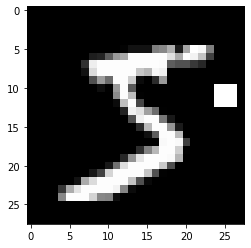

In [11]:
# display the first modified training image
plt.imshow(x_tr_cut[0, 0], cmap='gray')
plt.show()

**Answer**. [Write your solution here. Add cells as needed.]

In [12]:
from torch.utils import data

batch_size = 200
# 转换为 mini-batch
train_iter2 = data.DataLoader(data.TensorDataset(x_tr_cut.float(), y_train), batch_size, shuffle=True)
test_iter2 = data.DataLoader(data.TensorDataset(x_ts_cut.float(), y_test), batch_size, shuffle=False)

In [16]:
num_epochs = 10
lr = 0.01
ctx = device
# 有 feature_net 的网络
fine_net = tune_net(ctx)
## 打印 train_loss, train_acc, test_acc
fine_net_metric = train_model(fine_net, train_iter2, test_iter2, num_epochs, lr, ctx)

0 [0.2669313360502322, 0.9344833333333333, 0.9619]
1 [0.141679997574538, 0.96555, 0.9635]
2 [0.13322195671498777, 0.9673333333333334, 0.9632]
3 [0.12834526741256316, 0.9686, 0.962]
4 [0.12575038690119983, 0.96875, 0.965]
5 [0.12316020347177982, 0.96935, 0.9649]
6 [0.12110256279508273, 0.9696, 0.9647]
7 [0.11934442209079861, 0.9699333333333333, 0.9664]
8 [0.11808202559749285, 0.9700166666666666, 0.963]
9 [0.11701808537046114, 0.9704, 0.9656]


In [15]:
num_epochs = 10
lr = 0.01
ctx = device
# 简单网络
net = simple_net(ctx)
## 打印 train_loss, train_acc, test_acc
net_metric = train_model(net, train_iter2, test_iter2, num_epochs, lr, ctx)

0 [2.8120475745201112, 0.18361666666666668, 0.2005]
1 [1.9773447461922964, 0.24755, 0.2438]
2 [1.9647116732597352, 0.243, 0.2974]
3 [1.8964827688535055, 0.26975, 0.301]
4 [1.853070008357366, 0.28478333333333333, 0.2098]
5 [2.0184892431894936, 0.2125, 0.2152]
6 [2.004334104061127, 0.21796666666666667, 0.2118]
7 [2.0061639066537222, 0.21161666666666668, 0.2127]
8 [1.997455381155014, 0.21921666666666667, 0.2138]
9 [2.0037748448053994, 0.21351666666666666, 0.2158]
